In [1]:
import torch
import torchvision
import time
from torch import nn
from torch import optim
from torch.utils import data
from Validate import validate_net
from Test import test_net
from misc import print_metrics, training_curve 
from PIL import Image
import os
import re
import argparse
from collections import defaultdict
import numpy as np
import logging
import csv
from torchvision import transforms, datasets, models
import sklearn.metrics as mtc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pathlib

In [2]:
###########################
# Checking if GPU is used
###########################

use_cuda=torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device=torch.device("cuda:0" if use_cuda else "mps" if use_mps else "cpu")
device

device(type='cpu')

In [3]:
########################################
# Setting basic parameters for the model
########################################           
         
batch_size=32
max_epochs=30
lr=0.0001

In [4]:
# directory of dataset
dir_original = "./../GrapevineDS"

# name of new dataset
dir_processed = "./../data_processed"


In [5]:
# data_dir = pathlib.Path(dir_original)

# set_samples = ['train', 'validation', 'test']
# print("set_samples: ", set_samples, "\n")

# CLASS_NAMES = np.array([item.name for item in sorted(data_dir.glob('*'))])												
# print("class: ", CLASS_NAMES, "\n")

# N_IMAGES = np.array([len(list(data_dir.glob(item.name+'/*.jpg'))) for item in sorted(data_dir.glob('*'))])			# number of images for class
# print("number of images for class: ", N_IMAGES, "\n")

# N_samples = np.array([(int(np.around(n*60/100)), int(np.around(n*15/100)), int(np.around(n*25/100))) for n in N_IMAGES])	# number of images for set (train,validation,test)
# print("split of dataset: \n ", N_samples, "\n")


### Preprocessing Dataset

In [6]:
# #size of new images
# # size of new images
# size = 1280, 720

# # Create the new dataset
# # Split Dataset (also resize and rotate)

# try:
#     # Check if dir_processed exists and is a directory
#     if not os.path.isdir(dir_processed):
#         # If it's not a directory, create it
#         os.makedirs(dir_processed)
# except OSError as err:
#     print(err)

# # Now create subdirectories for sets and classes
# for set_tag in set_samples:
#     os.makedirs(os.path.join(dir_processed, set_tag),exist_ok=True)
#     for class_name in CLASS_NAMES:
#         os.makedirs(os.path.join(dir_processed, set_tag, class_name), exist_ok=True)

In [7]:
# # SPLIT DATASET (and resize) *************************************
# print("Split dataset.")

# i=0
# j=0
# k=0
# for class_name in CLASS_NAMES: # "j" cambia con il tipo di pianta [0,3]

#     print("class name: ", class_name)

#     contatore_samples = 0
#     k=0

#     array = sorted(os.listdir(dir_original + '/' + class_name))
#     #random.shuffle(array)

#     for image_name in array: # "contatore" si azzera ad ogni campo 'train' 'validation' 'test'

#         print("image: ", i)
#         i=i+1
        
#         if contatore_samples==N_samples[j][k] and k+1  < len(N_samples[j]):    # "k" cambia con train, validation, e test
#             print("updating k: ", k)
#             print(len(N_samples[j]))
#             k+=1
#             contatore_samples=0


#         img=Image.open(dir_original +'/'+class_name+'/'+image_name)
#         l,_ = img.size
#         l=int(l)
        
        
#         if l==1080 or l==720:
        
#             transposed = img.transpose(Image.ROTATE_90)
#             transposed.thumbnail(size)
#             transposed.save(dir_processed+'/'+set_samples[k]+'/'+class_name+'/'+image_name)
        
#         else:
        
#             img.thumbnail(size)
#             img.save(dir_processed+'/'+set_samples[k]+'/'+class_name+'/'+image_name)

#         contatore_samples+=1

#     j+=1

In [9]:
PATH_DATASET = '../data_processed'
 
train_root_dir=os.path.join(PATH_DATASET, 'train')   # Example: "../../GastroVision22Aug/train"
val_root_dir= os.path.join(PATH_DATASET, 'validation') # Example: "../../GastroVision22Aug/val"
test_root_dir= os.path.join(PATH_DATASET, 'test') # Example: "../../GastroVision22Aug/test"
model_path=r'./checkpoints_30_32_0001/'  # set path to the folder that will store model's checkpoints

n_classes=2  # number of classes used for training

global val_f1_max


try:
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))
except OSError as err:
    print(err)
    
print('train root', train_root_dir)

print("Directory '% s' created" % model_path)
filename='results_e'+str(max_epochs)+'_'+'b'+str(batch_size)+'_'+'lr'+str(lr)+'_'+'mobilenet'   #filename used for saving epoch-wise training details and test results 

train root ../data_processed\train
Directory './checkpoints_30_32_0001/' created


In [10]:
# ####################################
# # Training
# ####################################

trans={
 # Train uses data augmentation
 'train':
 transforms.Compose([
     #transforms.Resize((224, 224)),
     #transforms.RandomRotation(degrees=15),
     #transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     #transforms.Normalize([0.4762, 0.3054, 0.2368], [0.3345, 0.2407, 0.2164])
]),
 # Validation does not use augmentation
 'valid':
 transforms.Compose([
#          transforms.Resize((224,224)),
     transforms.ToTensor(),
#          transforms.Normalize([0.4762, 0.3054, 0.2368], [0.3345, 0.2407, 0.2164])
 ]),

 # Test does not use augmentation
 'test':
 transforms.Compose([
#          transforms.Resize((224,224)),
     transforms.ToTensor(),
#          transforms.Normalize([0.4762, 0.3054, 0.2368], [0.3345, 0.2407, 0.2164])
 ]),
}

In [22]:
class train:
    def __init__(self):

#         transform=trans['valid']
        #Generators
        training_dataset= datasets.ImageFolder(train_root_dir, transform=trans['train'])
        validation_dataset= datasets.ImageFolder(val_root_dir, transform=trans['valid'])
        test_dataset= datasets.ImageFolder(test_root_dir, transform=trans['test'])
        
        self.training_generator=data.DataLoader(training_dataset,batch_size,shuffle=True) # ** unpacks a dictionary into keyword arguments
        self.validation_generator=data.DataLoader(validation_dataset,batch_size)
        self.test_generator=data.DataLoader(test_dataset,batch_size)
       
        print('Number of Training set images:{}'.format(len(training_dataset)))
        print('Number of Validation set images:{}'.format(len(validation_dataset)))
        print('Number of Test set images:{}'.format(len(test_dataset)))
        
    def train_net(self):
        
        #Initialize model
        model = torchvision.models.mobilenet_v2(weights=True).to(device)   # make weights=True if you want to download pre-trained weights
        
        
#         model.load_state_dict(torch.load('./densenet121.pth',map_location='cuda'))   # provide a .pth path for already downloaded weights; otherwise comment this line out
        print(model.classifier[1].in_features)
        
        # Option to freeze model weights
        for param in model.parameters():
            param.requires_grad = True                       # Set param.requires_grad = False if you want to train only the last updated layers and freeze all other layers
        
        n_inputs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
                      nn.Linear(n_inputs, n_classes),                  
                      nn.LogSoftmax(dim=1))
        
       
        model.to(device)
        optimizer=optim.Adam(model.parameters(), lr, weight_decay=1e-4)
        scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=4,verbose=True)
        criterion = nn.NLLLoss()
        val_f1_max=0.0
        epochs=[]
        lossesT=[]
        lossesV=[]

        for epoch in range(max_epochs):
            print('Epoch {}/{}'.format(epoch+1,max_epochs))
            print('-'*10)
            
            since=time.time()
            train_metrics=defaultdict(float)
            total_loss=0
            running_corrects=0
            num_steps=0
            
            all_labels_d = torch.tensor([], dtype=torch.long).to(device)
            all_predictions_d = torch.tensor([], dtype=torch.long).to(device)
            all_predictions_probabilities_d = torch.tensor([], dtype=torch.float).to(device)
            
            model.train()
            
            #Training
            for image, labels in self.training_generator:
                #Transfer to GPU:
                
                image, labels = image.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(image)
                predicted_probability, predicted  = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
              
                num_steps+=image.size(0)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss+=loss.item()*image.size(0)
           
                running_corrects += torch.sum(predicted == labels.data)
                all_labels_d = torch.cat((all_labels_d, labels), 0)
                all_predictions_d = torch.cat((all_predictions_d, predicted), 0)
                all_predictions_probabilities_d = torch.cat((all_predictions_probabilities_d, predicted_probability), 0)
                
                
            y_true = all_labels_d.cpu()
            y_predicted = all_predictions_d.cpu()  # to('cpu')
            valset_predicted_probabilites = all_predictions_probabilities_d.cpu()  # to('cpu')
            
            
            #############################
            # Standard metrics 
            #############################
        
            train_micro_precision=mtc.precision_score(y_true, y_predicted, average="micro")     
            train_micro_recall=mtc.recall_score(y_true, y_predicted, average="micro")
            train_micro_f1=mtc.f1_score(y_true, y_predicted, average="micro")  
        
            train_macro_precision=mtc.precision_score(y_true, y_predicted, average="macro")     
            train_macro_recall=mtc.recall_score(y_true, y_predicted, average="macro")
            train_macro_f1=mtc.f1_score(y_true, y_predicted, average="macro")  
        
            train_mcc=mtc.matthews_corrcoef(y_true, y_predicted)
             
            
            train_metrics['loss']=total_loss/num_steps
        
            train_metrics['micro_precision']=train_micro_precision
            train_metrics['micro_recall']=train_micro_recall
            train_metrics['micro_f1']=train_micro_f1
            train_metrics['macro_precision']=train_macro_precision
            train_metrics['macro_recall']=train_macro_recall
            train_metrics['macro_f1']=train_macro_f1
            train_metrics['mcc']=train_mcc
            
            print('Training...')
            print('Train_loss:{:.3f}'.format(total_loss/num_steps))
           
            
            print_metrics(train_metrics,num_steps)

            ############################
            # Validation
            ############################
            
            model.eval()
            with torch.no_grad():
                val_loss, val_metrics, val_num_steps=validate_net(model,self.validation_generator,device,criterion)
                
            scheduler.step(val_loss)
            epochs.append(epoch)
            lossesT.append(total_loss/num_steps)
            lossesV.append(val_loss)
            
            print('.'*5)
            print('Validating...')
            print('val_loss:{:.3f}'.format(val_loss))
        
            print_metrics(val_metrics,val_num_steps)


            ##################################################################
            # Writing epoch-wise training and validation results to a csv file 
            ##################################################################

            key_name=['Epoch','Train_loss','Train_micro_precision','Train_micro_recall','Train_micro_f1','Train_macro_precision','Train_macro_recall','Train_macro_f1','Train_mcc','Val_loss','Val_micro_precision','Val_micro_recall','Val_micro_f1','Val_macro_precision','Val_macro_recall','Val_macro_f1','Val_mcc']
            train_list=[]
            train_list.append(epoch)

            try:

                with open(filename+str('.csv'), 'a',newline="") as f:
                    wr = csv.writer(f,delimiter=",")
                    if epoch==0:
                        wr.writerow(key_name)

                    for k, vl in train_metrics.items():
                        train_list.append(vl)

                    train_list.append(val_loss)

                    for k, vl in val_metrics.items():
                        train_list.append(vl)
                    zip(train_list)
                    wr.writerow(train_list)


            except IOError:
                print("I/O Error")

            
            ##############################
            # Saving best model 
            ##############################
            
            if val_metrics['micro_f1']>=val_f1_max:
                print('val micro f1 increased ({:.6f}-->{:.6f}).Saving model'.format(val_f1_max,val_metrics['micro_f1']))
                
                torch.save({'epoch':epoch+1,
                            'model_state_dict':model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict(), 
                            'loss':val_loss},model_path+f'/C_{epoch+1}_{batch_size}.pth')
                best_model_path=model_path+f'/C_{epoch+1}_{batch_size}.pth'
               
                val_f1_max=val_metrics['micro_f1']
                

            print('-'*10)
       
        time_elapsed=time.time()-since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
        training_curve(epochs,lossesT,lossesV)
        epochs.clear()
        lossesT.clear()
        lossesV.clear()
        

        ############################
        #         Test
        ############################
        test_list=[]
        print('Best model path:{}'.format(best_model_path))
        best_model=torchvision.models.mobilenet_v2(weights=False).to(device)
        
        n_inputs = best_model.classifier[1].in_features
        best_model.classifier = nn.Sequential(
                      nn.Linear(n_inputs, n_classes),               
                      nn.LogSoftmax(dim=1))

 
        checkpoint=torch.load(best_model_path,map_location=device)   # loading best model
        best_model.load_state_dict(checkpoint['model_state_dict'])
        best_model.to(device)
        best_model.eval()
        with torch.no_grad():
       	       test_loss, test_metrics, test_num_steps=test_net(best_model,self.test_generator,device,criterion)

        
        print_metrics(test_metrics,test_num_steps)
        test_list.append(test_loss)
     

        for k, vl in test_metrics.items():      
            test_list.append(vl)              # append metrics results in a list
  
  
  
        ##################################################################
        # Writing test results to a csv file 
        ##################################################################

        key_name=['Test_loss','Test_micro_precision','Test_micro_recall','Test_micro_f1','Test_macro_precision','Test_macro_recall','Test_macro_f1','Test_mcc']
        try:

                with open(filename+str('.csv'), 'a',newline="") as f:
                    wr = csv.writer(f,delimiter=",")
                    wr.writerow(key_name)
                    zip(test_list)
                    wr.writerow(test_list) 
                    wr.writerow("") 
        except IOError:
                print("I/O Error")  
        return val_metrics, test_metrics

INFO: Using device: cpu
INFO: Starting training:
             Epochs: 30
             Batch Size: 32
             Learning Rate: 0.0001
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Number of Training set images:1062
Number of Validation set images:265
Number of Test set images:443
1280
Epoch 1/30
----------
Training...
Train_loss:0.125
loss:0.125035,micro_precision:0.960452,micro_recall:0.960452,micro_f1:0.960452,macro_precision:0.960723,macro_recall:0.960409,macro_f1:0.960443,mcc:0.921131
.....
Validating...
val_loss:0.070
micro_precision:0.962264,micro_recall:0.962264,micro_f1:0.962264,macro_precision:0.964789,macro_recall:0.962406,macro_f1:0.962221,mcc:0.927192
val micro f1 increased (0.000000-->0.962264).Saving model
----------
Epoch 2/30
----------
Training...
Train_loss:0.007
loss:0.006838,micro_precision:0.999058,micro_recall:0.999058,micro_f1:0.999058,macro_precision:0.999064,macro_recall:0.999055,macro_f1:0.999058,mcc:0.998118
.....
Validating...
val_loss:0.052
micro_precision:0.973585,micro_recall:0.973585,micro_f1:0.973585,macro_precision:0.974820,macro_recall:0.973684,macro_f1:0.973571,mcc:0.948504
val micro f1 increased (0.962264-->0.973585).Saving m

Training...
Train_loss:0.000
loss:0.000277,micro_precision:1.000000,micro_recall:1.000000,micro_f1:1.000000,macro_precision:1.000000,macro_recall:1.000000,macro_f1:1.000000,mcc:1.000000
.....
Validating...
val_loss:0.009
micro_precision:0.996226,micro_recall:0.996226,micro_f1:0.996226,macro_precision:0.996241,macro_recall:0.996241,macro_f1:0.996226,mcc:0.992481
----------
Epoch 21/30
----------
Training...
Train_loss:0.000
loss:0.000376,micro_precision:1.000000,micro_recall:1.000000,micro_f1:1.000000,macro_precision:1.000000,macro_recall:1.000000,macro_f1:1.000000,mcc:1.000000
.....
Validating...
val_loss:0.004
micro_precision:1.000000,micro_recall:1.000000,micro_f1:1.000000,macro_precision:1.000000,macro_recall:1.000000,macro_f1:1.000000,mcc:1.000000
val micro f1 increased (1.000000-->1.000000).Saving model
----------
Epoch 22/30
----------
Training...
Train_loss:0.000
loss:0.000181,micro_precision:1.000000,micro_recall:1.000000,micro_f1:1.000000,macro_precision:1.000000,macro_recall:

C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy of the network on the 443 test images: 99.097069 %
[[218   4]
 [  0 221]]
taking class names to plot CM
Generating confution matrix
Confusion matrix, without normalization
[[218   4]
 [  0 221]]
Finished confusion matrix drawing...
              precision    recall  f1-score   support

        esca       1.00      0.98      0.99       222
     healthy       0.98      1.00      0.99       221

    accuracy                           0.99       443
   macro avg       0.99      0.99      0.99       443
weighted avg       0.99      0.99      0.99       443

micro_precision:0.990971,micro_recall:0.990971,micro_f1:0.990971,macro_precision:0.991111,macro_recall:0.990991,macro_f1:0.990970,mcc:0.982102


(defaultdict(float,
             {'micro_precision': 1.0,
              'micro_recall': 1.0,
              'micro_f1': 1.0,
              'macro_precision': 1.0,
              'macro_recall': 1.0,
              'macro_f1': 1.0,
              'mcc': 1.0}),
 defaultdict(float,
             {'micro_precision': 0.9909706546275395,
              'micro_recall': 0.9909706546275395,
              'micro_f1': 0.9909706546275395,
              'macro_precision': 0.991111111111111,
              'macro_recall': 0.990990990990991,
              'macro_f1': 0.99097024052181,
              'mcc': 0.9821020947562044}))

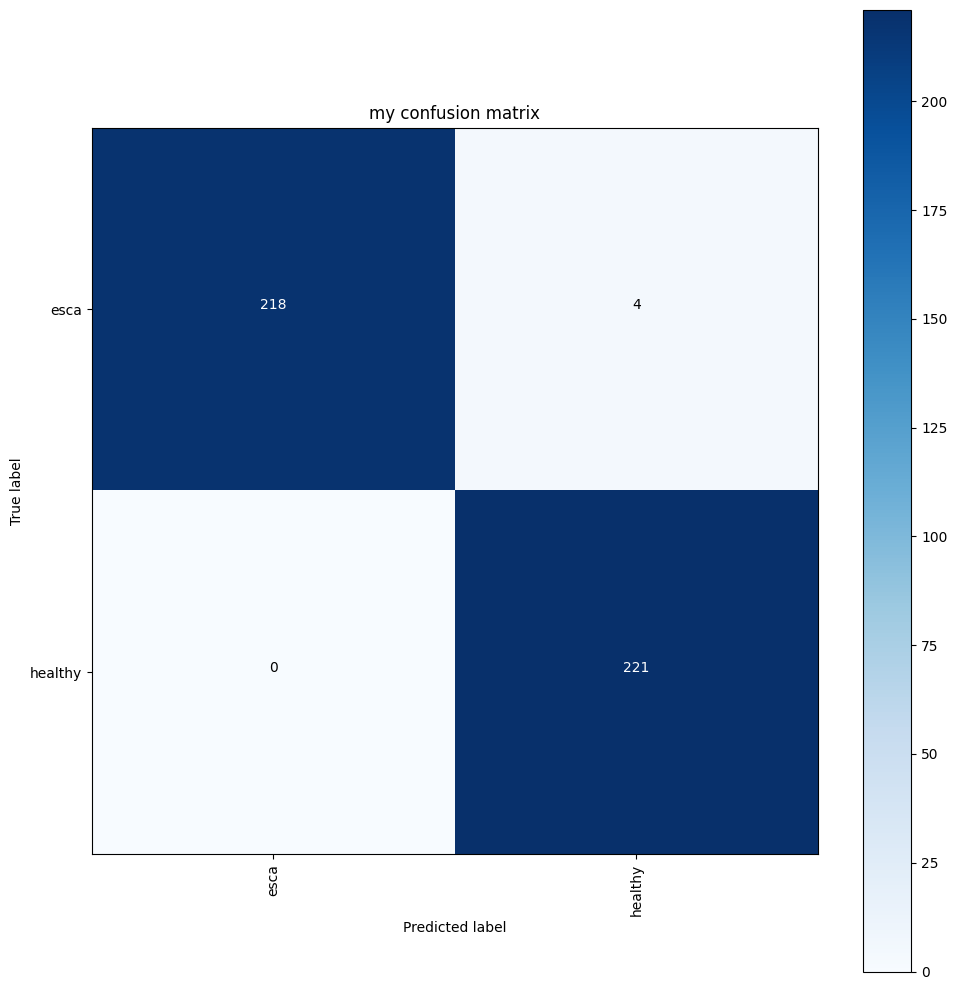

In [23]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logging.info(f'Using device: {device}')
logging.info(f'''Starting training:
             Epochs: {max_epochs}
             Batch Size: {batch_size}
             Learning Rate: {lr}''')
t=train()
t.train_net()

### Inference

In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of DenseNet-121
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [22]:
# Load your single image
PATH_DATASET = './../data_processed'

image_path = os.path.join(PATH_DATASET, 'test','healthy','healthy_662_cam3.jpg')  # Replace 'path_to_your_image.jpg' with the path to your image
image = Image.open(image_path)


In [23]:
# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

In [24]:
# Load the pre-trained model
model = torchvision.models.mobilenet_v2(pretrained=True)  # Assuming you want to use the pre-trained weights
model.eval()  # Set model to evaluation mode

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:

############################
#         Inference
############################
test_model_path = "./checkpoints_30_32_0001//C_30_32.pth"
n_classes = 2

test_model=torchvision.models.mobilenet_v2(weights=False).to(device)

n_inputs = test_model.classifier.in_features
test_model.classifier = nn.Sequential(
              nn.Linear(n_inputs, n_classes),               
              nn.LogSoftmax(dim=1))


checkpoint=torch.load(test_model_path,map_location=device)   # loading best model
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.to(device)
test_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
# Perform inference
with torch.no_grad():
    output = test_model(input_image)

    # Get the predicted class index
    _, predicted = torch.max(output, 1)
    predicted_class_index = predicted.item()
    
    # Interpret the results (assuming you have a class label mapping)
    class_labels = ['healthy','esca' ]  # Replace with your actual class labels
    predicted_class_label = class_labels[predicted_class_index]
    print('Predicted class:', predicted_class_label)

Predicted class: healthy


In [27]:
print('Predicted class:', predicted_class_label)

Predicted class: healthy
